In [1]:
BATCH_SIZE = 1024
PAD_SIZE = 70

# Preprocessing

In [2]:
import os

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [4]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["solved", "interrupted"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(["solved", "interrupted"])

Found 34122 files belonging to 2 classes.
Using 27298 files for training.


2023-10-17 22:06:56.010469: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-17 22:06:56.010502: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-17 22:06:56.010505: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-17 22:06:56.010707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-17 22:06:56.010723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 34122 files belonging to 2 classes.
Using 6824 files for validation.


In [5]:
for X,y in train_dataset.take(1):
    pass

In [6]:
#y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
#y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
#y = y == 1
print(y.numpy().mean())

0.4453125


In [7]:
df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: B
instance: CL
+-----------+
2D Packing MIP with Time Limit 11.784904202027246 [s] in Truck P322010907
Stack 0 with items: ['0090016100_26102022000979']
Stack 1 with items: ['0090016100_26102022000979']
Stack 2 with items: ['0090016100_26102022000979']
Stack 3 with items: ['0090016100_26102022000979']
Stack 4 with items: ['0090016100_26102022000979']
Stack 5 with items: ['0090016100_26102022000979']
Stack 6 with items: ['0090016100_26102022000979']
Stack 7 with items: ['0090016100_26102022000979']
Stack 8 with items: ['0090016100_26102022000979']
Stack 9 with items: ['0090016100_26102022000979']
Stack 10 with items: ['0090016100_26102022000979']
Stack 11 with items: ['0090016100_26102022000979']
Stack 12 with items: ['0090016100_26102022000979']
Stack 13 with items: ['0090016100_26102022000979']
Stack 14 with items: ['0090016100_26102022001965']
Stack 15 with items: ['0090016100_26102022001965']
Stack 16 with items: ['0090016100_26102022001965']
Stack 17 with items: ['00900161

# Loading CSVs

In [8]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
1925700,null,90016900,"""GRF1""","""682003577R""","""ECM---6632""",2.4,2.1,1.49,0.5186,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.445
22060301,null,90016900,"""169GB-10""","""8200771281""","""SFD---0760""",1.2,1.0,0.93,0.62582,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
6681302,null,90016900,"""169GD-60""","""963010148R""","""SLI---2112""",1.206,1.01,1.093,0.08744,0.0,"""C""","""BY""","""0090016900_270…",false,false,1.093
22060301,null,90016900,"""169GB-10""","""8200784370""","""SLI---0760""",1.2,1.0,0.93,0.18548,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
90016100,"""K11""",90016900,"""GRD1""","""100018674R""","""MFM---0474""",2.3,1.6,1.0,1.57,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.955


In [9]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730405""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730407""","""A""","""AS"""


In [10]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
])

truck_dims.collect().head()

truck_id,Length,Width,Weight,dataset,instance
str,f64,f64,f64,str,str
"""P187721701""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730401""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730403""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730405""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730407""",14.94,2.5,24.0,"""A""","""AS"""


In [11]:
def append_truck_info(df: pl.DataFrame, truck_dims: pl.DataFrame) -> pl.DataFrame:
    """
    Add trucks into dataset adding them as rows
    with exactly the same features as the original df

    
    """

    df = df.drop(["items", "Nesting height", "NestedHeight"])
    truck_dims = (
        truck_dims
        .join(df, on = ["dataset", "instance", "truck_id"])
        .unique()
        #.drop(["dataset", "instance", "truck_id"])
    )
    
    df = df.drop(["dataset", "instance", "truck_id"])
    df = df.with_columns([
        pl.lit(False).alias("truck")
    ])
    
    truck_dims = truck_dims.with_columns([
        pl.lit(False).alias("ForcedLength"),
        pl.lit(False).alias("ForcedWidth"),
        pl.lit("0-0-0").alias("packing_order"),
        pl.lit(True).alias("truck")
    ])
    
    truck_dims = truck_dims.collect()[df.columns].lazy().unique()

    df = pl.concat([df, truck_dims])
    df = df.sort(["index", "truck"])
    
    return df



In [12]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items, join_items, group_items_by_stack, join_truck_loading_order

In [13]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .pipe(append_truck_info, truck_dims)
    .collect()
    .to_numpy()
)

X

array([[0, 0.78, 0.57, ..., True, '1-1-1', False],
       [0, 0.78, 0.57, ..., True, '1-1-1', False],
       [0, 0.78, 0.57, ..., True, '1-1-1', False],
       ...,
       [1023, 2.28, 1.47, ..., False, '1-1-1', False],
       [1023, 2.28, 1.47, ..., False, '1-1-1', False],
       [1023, 13.5, 2.44, ..., False, '0-0-0', True]], dtype=object)

In [14]:
X.shape

(20067, 8)

In [15]:
def get_tensor_representation(X):
    for i in range(1):
        
        indices = np.unique(X[:, 0])
        indices = np.sort(indices)

        # (batch_size, ?, features)
        X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

        # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
        #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
        packing_clm = 6
        for i, x in enumerate(X):
            packing_order = x[:,packing_clm]
            stops = np.unique(packing_order)
            stops = np.sort(stops)
            stops = {stop: j for j, stop in enumerate(stops)}
            stops = [stops[order] for order in packing_order]
            X[i][:,packing_clm] = stops

        # pad the variable length number of stacks into fixed
        #  (batch_size, pad_size, features)
        X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float64")
        # drop the index column (batch_size, pad_len, n_features)
        X = X[:,:,1:].astype(float)
        return X

c = get_tensor_representation(X)
c

array([[[0.78    , 0.57    , 0.43288 , ..., 1.      , 1.      ,
         0.      ],
        [0.78    , 0.57    , 0.43288 , ..., 1.      , 1.      ,
         0.      ],
        [0.78    , 0.57    , 0.43288 , ..., 1.      , 1.      ,
         0.      ],
        ...,
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ]],

       [[2.4     , 1.2     , 0.22656 , ..., 0.      , 1.      ,
         0.      ],
        [2.4     , 1.2     , 0.22644 , ..., 0.      , 1.      ,
         0.      ],
        [3.2     , 2.4     , 0.444778, ..., 0.      , 1.      ,
         0.      ],
        ...,
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.  

In [16]:
c[0, :, :]

array([[ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.     ,  1.     ,  1.     ,
         0.     ],
       [ 0.78   ,  0.57   ,  0.43288,  0.  

In [17]:
def polars_transformation(X) -> pl.DataFrame:
    """
    """
    
    df = pl.DataFrame({"raw": X.numpy().astype(str)})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)
    return X

#polars_transformation(X)

# DNN

In [18]:
N_FEATURES = c.shape[-1]

In [19]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda

#help(Masking)
#help(MultiHeadAttention)
#help(Reshape)
#help(Dropout)
#help(Lambda)

In [20]:
# Hyperparameter. Expand input features into more. Essentially features engineering ?!?
upscale_size = N_FEATURES
#upscale_size = 16
upscale_layers = 0

# number of encoder blocks
n_blocks = 5 #3
num_heads = 4
key_dim = int(upscale_size/num_heads)
use_bias = True
encoder_dropout =  1/(2+n_blocks*2); print(f"Encoder Dropout: {encoder_dropout:.1%}")


# number of squeeze layers:
n_squeeze = N_FEATURES # 16

merge = "add" # "add" # "squeeze"

# number of fully connected layers with droput
fully_connected_units = [] # [16]
fully_connected_dropout_rate = 0.5

# activation function
activation = "gelu" # "relu" "gelu" "selu" "swish"




# Learning Rate
initial_learning_rate = 10e-3
lr_decay = 0.9

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_learning_rate)
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)

# Loss Function
#loss_fn = tf.keras.losses.BinaryCrossentropy(name="binary_crossentropy",)

# Focal Loss gamma:
gamma = 1.2 # 6
alpha = 1-y.numpy().mean() # inverse class frequency

loss_fn = tf.keras.losses.BinaryFocalCrossentropy(gamma=gamma,
                                                  alpha = alpha,
                                                  name='binary_focal_crossentropy')



Encoder Dropout: 8.3%


In [21]:
# build a model using the functional API:
from keras import backend as K

from tensorflow.keras import Model


# Input
input_layer = Input(shape=(PAD_SIZE, N_FEATURES))

# Masking padded input
masking_layer = Masking(mask_value=0,
                        input_shape=(PAD_SIZE, N_FEATURES),
                        dtype=tf.float16, # float, # tf.float16
                        name="MaskingLayer"
                       )
x = masking_layer(input_layer)

#batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
#x = batch_norm_layer(masking_layer)

# Stack Level Feature Engineering
for i in range(1, upscale_layers+1):
    upscale_layer = Dense(upscale_size, activation=activation)
    x = upscale_layer(x)


# Encoder Block
for i in range(1, n_blocks+1):
    # Self attention with add and layer norm
    self_attention_layer = MultiHeadAttention(
        #num_heads=4, key_dim=4, attention_axes=(1, 2), # change this if you get an error
        num_heads=num_heads, key_dim=key_dim,
        dropout=encoder_dropout,                                   # Hyperparameter
        use_bias=use_bias,  # usually False, but technically Hyperparameter
        name=f"Encoder{i}-SelfAttentionLayer"
    )
    self_attention_layer = self_attention_layer(query=x,
                                                value=x,
                                                key = x,
                                                use_causal_mask=False,
                                               )
    add1 = Add(name=f"Encoder{i}-FirstAdditionLayer")
    add1 = add1([x, self_attention_layer])

    layernorm1 = LayerNormalization(name=f"Encoder{i}-FirstLayerNormalization")
    x = layernorm1(add1)

    # second add and norm
    feed_forward_layer = Dense(upscale_size, activation=activation, name=f"Encoder{i}-FeedForwardLayer")
    feed_forward_layer = feed_forward_layer(x)

    add2 = Add(name=f"Encoder{i}-SecondAdditionLayer")
    add2 = add2([x, feed_forward_layer])

    layernorm2 = LayerNormalization(name=f"Encoder{i}-SecondLayerNormalization")
    x = layernorm2(add2)



if merge == "add":
    # After Attention, reduce to single dimension
    add_across_dim = Lambda(lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
                            output_shape=lambda s: (s[0], s[2]),
                            name = "ReduceViaSum"
                           )
    x = add_across_dim(x)


#if merge == "squeeze":
#    # After Attention, reduce to single dimension
#    #permute = Permute(dims=(2,1), name="SwitchStackFeatureDimensions") # switch the first and the second dim
#    #x = permute(x)
#    squeeze = Dense(n_squeeze, activation=activation, name="SqueezeAfterAttention")
#    x = squeeze(x)
#    #reshape = Reshape(target_shape=(upscale_size*n_squeeze,))
#    #x = reshape(x)
#    reshape = Lambda(lambda x: tf.squeeze(x))
#    x = reshape(x)
    




#dropout_layer = Dropout(fully_connected_dropout_rate,
#                            name = f"FullyConnectedDropoutLayer-0")
#x = dropout_layer(x)


# Fully Connected Layer + Droput
#for i, units in enumerate(fully_connected_units):
#    
#    full_connected_layer = Dense(units=units, activation=activation,name=f"FullyConnectedLayer-{i+1}")
#    x = full_connected_layer(x)
#
#    dropout_layer = Dropout(fully_connected_dropout_rate,
#                            name = f"FullyConnectedDropoutLayer-{i+1}")
#    x = dropout_layer(x)


outputs = Dense(1, activation='sigmoid', name = "PredictionLayer")
outputs = outputs(x)

reshape = Lambda(lambda x: tf.squeeze(x))
outputs =  reshape(outputs)

model = Model(inputs=input_layer,
              #outputs=x
              outputs=outputs,
             )

In [22]:
model(c).shape

TensorShape([1024])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 70, 7)]              0         []                            
                                                                                                  
 MaskingLayer (Masking)      (None, 70, 7)                0         ['input_1[0][0]']             
                                                                                                  
 Encoder1-SelfAttentionLaye  (None, 70, 7)                131       ['MaskingLayer[0][0]',        
 r (MultiHeadAttention)                                              'MaskingLayer[0][0]',        
                                                                     'MaskingLayer[0][0]']        
                                                                                              

In [24]:
d = model(c)
d

<tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([0.30414405, 0.26670638, 0.2607687 , ..., 0.25872326, 0.2580967 ,
       0.2602354 ], dtype=float32)>

(array([286., 258., 229., 203.,  31.,   9.,   7.,   0.,   0.,   1.]),
 array([0.22896953, 0.26793224, 0.30689493, 0.34585765, 0.38482034,
        0.42378303, 0.46274576, 0.50170845, 0.54067117, 0.57963383,
        0.61859655]),
 <BarContainer object of 10 artists>)

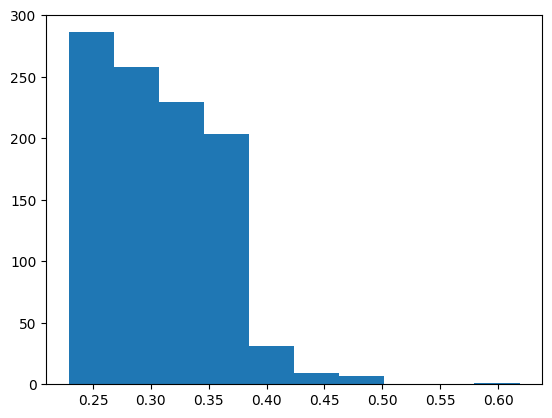

In [25]:
import matplotlib.pyplot as plt
plt.hist(d.numpy().reshape(-1))

In [26]:
n_epochs = 100
n_steps = len(train_dataset) // BATCH_SIZE


mean_loss = keras.metrics.Mean(name = "Mean-Loss")
val_mean_loss = keras.metrics.Mean(name = "Val-Mean-Loss")




metrics = [
    tf.keras.metrics.Precision(name = "Precision"),
    tf.keras.metrics.Recall(name = "Sensitivity"),
    tf.keras.metrics.AUC(curve='PR', name="Average Precision"),
    tf.keras.metrics.BinaryAccuracy(name = "Accuarcy")
]

val_metrics = [
    tf.keras.metrics.Precision(name = "Val-Precision"),
    tf.keras.metrics.Recall(name = "Val-Sensitivity"),
    tf.keras.metrics.AUC(curve='PR', name="Val-Average Precision"),
    tf.keras.metrics.BinaryAccuracy(name = "Val-Accuarcy")
]

## Training Loop

In [27]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result()*100:.2f}%"
                          for m in [loss] + (metrics or [])])
    
    end = ""# if iteration < total else "\n"
    print(f"\r{iteration+1}/{total} | " + metrics,
          end=end)



In [28]:
@tf.function
def model_pass(X_batch, y_batch, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        y_pred = model(X_batch, training=training)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
        
        if training:
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    return loss, y_pred


In [29]:
history = pl.DataFrame()

for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch}/{ n_epochs}")
    track = {"Epoch": epoch}
    
    for step, (X_batch, y_batch) in enumerate(train_dataset):
        y_batch = y_batch.numpy()
        X_batch = polars_transformation(X_batch)
        loss, y_pred = model_pass(X_batch, y_batch, training=True)
        mean_loss(loss)
        
        for metric in metrics:
            metric(y_batch.reshape(-1), y_pred.numpy().reshape(-1))
    
        print_status_bar(step, len(train_dataset), mean_loss, metrics)
    
    print("\n\n")
    #print_status_bar(len(train_dataset), len(train_dataset), mean_loss, metrics)
    
    # exponential decay learning rate
    optimizer.lr = optimizer.lr * lr_decay

    
    track.update({m.name: m.result() for m in [mean_loss]+metrics})
    for metric in [mean_loss] + metrics:
        metric.reset_states()
    
    # Validation Step
    for step, (X_batch, y_batch) in enumerate(val_dataset):
        y_batch = y_batch.numpy()
        X_batch = polars_transformation(X_batch)
        loss, y_pred = model_pass(X_batch, y_batch, training=False)
        val_mean_loss(loss)
        
        for metric in val_metrics:
            metric(y_batch.reshape(-1), y_pred.numpy().reshape(-1))
    
        print_status_bar(step, len(val_dataset), mean_loss, val_metrics)
        
    
    track.update({m.name: m.result() for m in [val_mean_loss]+val_metrics})
    for metric in [val_mean_loss] + val_metrics:
        metric.reset_states()
    
    print("\n", "-"*100, "\n")
    history = pl.concat([history, pl.DataFrame(track)])
    
    # early stopping if no improvements after 3 Epochs
    if not all((history["Val-Average Precision"] - history["Val-Average Precision"].shift(1)).tail(3) < 0):
        continue
    # only if we start to overfit
    if history["Val-Average Precision"][-1] > history["Average Precision"][-1]:
        continue
    if history["Val-Mean-Loss"][-1] < history["Mean-Loss"][-1]:
        continue
    print(f"Early Stopping after {epoch} epochs")
    print("No improvements in Average Precision in the validation set have been observed since 2 Epochs")
    break

Epoch 1/100


2023-10-17 22:07:12.979074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 | Mean-Loss: 20.41% - Precision: 73.95% - Sensitivity: 79.65% - Average Precision: 79.66% - Accuarcy: 78.14%


7/7 | Mean-Loss: 0.00% - Val-Precision: 75.12% - Val-Sensitivity: 84.34% - Val-Average Precision: 84.63% - Val-Accuarcy: 80.58%
 ---------------------------------------------------------------------------------------------------- 

Epoch 2/100
27/27 | Mean-Loss: 16.84% - Precision: 78.27% - Sensitivity: 84.12% - Average Precision: 85.93% - Accuarcy: 82.28%


7/7 | Mean-Loss: 0.00% - Val-Precision: 80.45% - Val-Sensitivity: 80.55% - Val-Average Precision: 87.99% - Val-Accuarcy: 82.62%
 ---------------------------------------------------------------------------------------------------- 

Epoch 3/100
27/27 | Mean-Loss: 15.89% - Precision: 78.55% - Sensitivity: 86.64% - Average Precision: 87.50% - Accuarcy: 83.28%


7/7 | Mean-Loss: 0.00% - Val-Precision: 83.52% - Val-Sensitivity: 74.73% - Val-Average Precision: 88.71% - Val-Accuarcy: 82.18%
 --------------------------------

<Axes: xlabel='Epoch'>

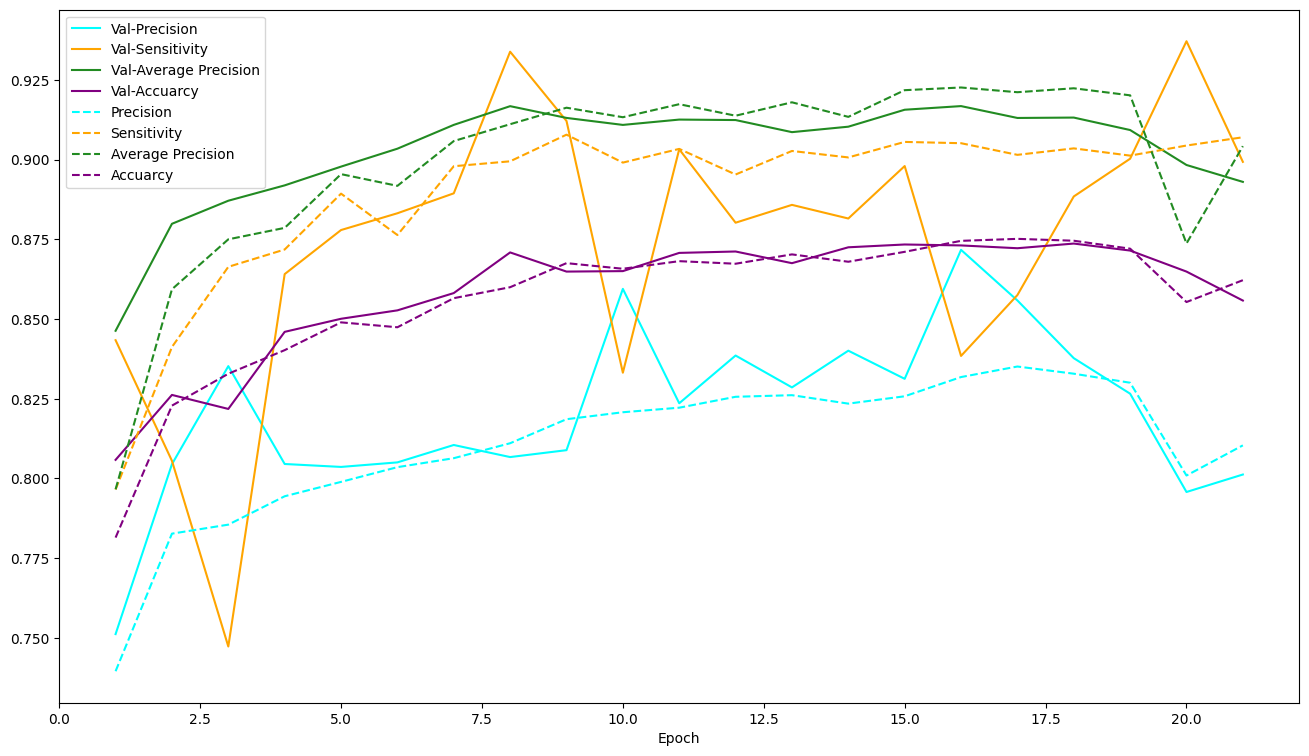

In [30]:
history = history.to_pandas().set_index("Epoch")

clms = history.columns

fig, ax = plt.subplots(figsize=(16, 9))

colors = ["cyan", "orange", "forestgreen", "purple"]

history[clms[clms.str.contains("Val-") & ~clms.str.contains("Loss")]].plot(ls="--", ax=ax, color = colors)
history[clms[~clms.str.contains("Val-") & ~clms.str.contains("Loss")]].plot(ls="-", ax=ax, color = colors);